In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

# from keras.applications.vgg16 import VGG16 # load VGG16 model from keras
# from keras.preprocessing.image import load_img # Using images library
# from keras.preprocessing.image import img_to_array # # convert image pixels to numpy for specific manipulations
# from keras.applications.vgg16 import preprocess_input # to prepare for new input
# from keras.applications.vgg16 import decode_predictions # for reporting probabilities

from keras import layers
from keras import models
from keras import optimizers

#For Keras
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

Using TensorFlow backend.
C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [2]:
# refer to deep learning book page 12 "introduction to convets"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# prepare an iterators for each dataset
train_it = train_datagen.flow_from_directory('data/images/train',
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     batch_size=32,
                                     class_mode='categorical',
                                     shuffle=True)

validate_it = train_datagen.flow_from_directory('data/images/validate',
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     batch_size=32,
                                     class_mode='categorical',
                                     shuffle=True)

train_batchX, train_batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (train_batchX.shape, train_batchX.min(), train_batchX.max()))
validate_batchX, validate_batchy = validate_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (validate_batchX.shape, validate_batchX.min(), validate_batchX.max()))

Found 225 images belonging to 5 classes.
Found 48 images belonging to 5 classes.
Batch shape=(32, 224, 224, 3), min=-1.000, max=1.000
Batch shape=(32, 224, 224, 3), min=-1.000, max=1.000


In [18]:
model = models.Sequential()

# NOTE:
# not sure what second parameter specifically does (#,#) 
# specify inputshapes 3rd param
# Conv2D --> (#,#) strides ?
# MaxPooling2D --> (#,#) pool size ?
# either adjust nodes or add layers and epochs for better results.. 

model.add(layers.Conv2D(200, (3, 3), 
          activation='relu',
          input_shape=(224, 224, 3)))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(24, activation='relu'))

model.add(layers.Dense(5, activation='softmax')) # 5 categories

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 222, 222, 200)     5600      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 111, 111, 200)     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 109, 109, 128)     230528    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 52, 52, 128)       147584    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 64)       

In [19]:
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
step_size_train = train_it.n//train_it.batch_size #np.ceil((train_it.n//train_it.batch_size)/2)

history = model.fit_generator(generator=train_it,
                                  validation_data=validate_it,
                                  validation_freq=2,
                                  steps_per_epoch=step_size_train,
                                  shuffle=True,
                                  epochs=45)

Epoch 1/45
7/7 [==============================] - 66s 9s/step - loss: 1.5073 - accuracy: 0.3731
Epoch 2/45
7/7 [==============================] - 77s 11s/step - loss: 1.4707 - accuracy: 0.4152 - val_loss: 1.6127 - val_accuracy: 0.2292
Epoch 3/45
7/7 [==============================] - 54s 8s/step - loss: 1.4475 - accuracy: 0.3889 - val_loss: 1.6127 - val_accuracy: 0.2292
Epoch 4/45
7/7 [==============================] - 77s 11s/step - loss: 1.4958 - accuracy: 0.3170 - val_loss: 1.6516 - val_accuracy: 0.1458
Epoch 5/45
7/7 [==============================] - 63s 9s/step - loss: 1.3944 - accuracy: 0.4093 - val_loss: 1.6516 - val_accuracy: 0.1458
Epoch 6/45
7/7 [==============================] - 67s 10s/step - loss: 1.4282 - accuracy: 0.3679 - val_loss: 1.6050 - val_accuracy: 0.2292
Epoch 7/45
7/7 [==============================] - 64s 9s/step - loss: 1.5303 - accuracy: 0.4249 - val_loss: 1.6050 - val_accuracy: 0.2292
Epoch 8/45
7/7 [==============================] - 66s 9s/step - loss: 1.4

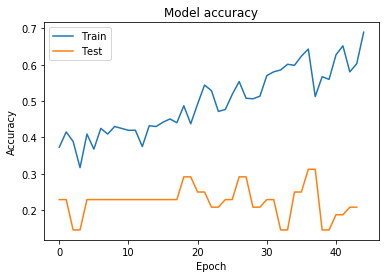

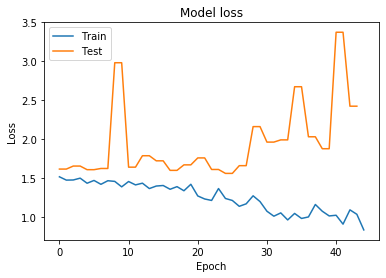

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
# test image 
test_it = ImageDataGenerator(preprocessing_function=preprocess_input)
test_it = test_it.flow_from_directory('data/images/test/',
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     batch_size=32,
                                     class_mode='categorical',
                                     shuffle=True,
                                     classes=['assault_rifles','grenade_launchers','pistols','shotguns','sniper_rifles']
                                     )

test_batchX, test_batchy = test_it.next()

print("labels: ", test_it.class_indices)


Found 8 images belonging to 5 classes.
labels:  {'assault_rifles': 0, 'grenade_launchers': 1, 'pistols': 2, 'shotguns': 3, 'sniper_rifles': 4}


In [24]:
result = model.predict(test_it)

for row in range(len(result)):
    biggest = np.argmax(result[row])
    for val in range(len(result[row])):
        if(val == biggest):
            result[row][val] = 1.
        else:
            result[row][val] = 0.

result

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

C:\Users\user\anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


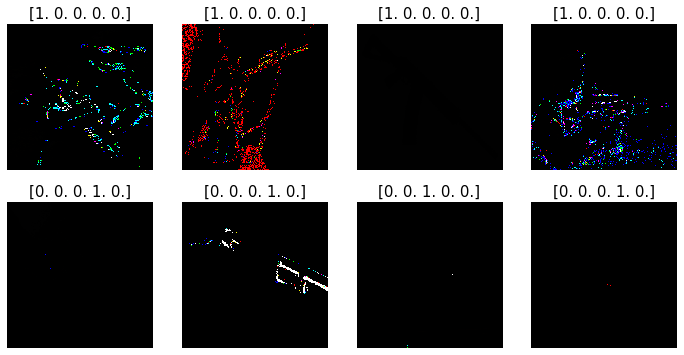

In [25]:
# plot function, used to plot images with labels 
def plots(ims, figsize=(12,6), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims= np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=15)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# we plot these samples of images and their labels 1 batch at a time.
plots(test_batchX, titles=result)